In [9]:
import torch
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet56", pretrained=True)
#from keras.models import load_model

Using cache found in /Users/maomao/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet56-187c023a.pt" to /Users/maomao/.cache/torch/hub/checkpoints/cifar10_resnet56-187c023a.pt


  0%|          | 0.00/3.39M [00:00<?, ?B/s]

In [18]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
epsilons = [0, .05, .1, .15, .2, .25, .3]
# 是否使用cuda
use_cuda = True
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
transform = transforms.Compose(
    [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
     transforms.Normalize(norm_mean, norm_std),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [38]:
#device = torch.device("cuda:0")
print(device)

cpu


In [28]:
#model = model.to(device)
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = (100.0 * correct / total)
print(test_accuracy)
print('Accuracy of the network on the 10000 test images: ', test_accuracy, '%%')

76.29
Accuracy of the network on the 10000 test images: %d %% 76.29


In [24]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 77 %
Accuracy of   car : 81 %
Accuracy of  bird : 70 %
Accuracy of   cat : 65 %
Accuracy of  deer : 76 %
Accuracy of   dog : 75 %
Accuracy of  frog : 76 %
Accuracy of horse : 82 %
Accuracy of  ship : 78 %
Accuracy of truck : 77 %


## FGSM attack

$$\begin{align}perturbed\_image = image + epsilon*sign(data\_grad) = x + \epsilon * sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))\end{align}$$

In [34]:
def unnormalize(img, mean = np.array(norm_mean), std = np.array(norm_std)):
  '''
   unnormalize the image that has been normalized with mean and std
  '''
  inverse_mean = - mean/std
  inverse_std = 1/std
  img = transforms.Normalize(mean=-mean/std, std=1/std)(img)
  return img

In [35]:
# https://github.com/catherine0422/CIFAR10-VGG19-FGSM-PGD/blob/main/.ipynb_checkpoints/simple%20adversarial%20attacks%20on%20CIFAR10-checkpoint.ipynb
def fgsm_attack(image, epsilon, data_grad):
    #d = epsilon * data_grad
    #print("When epsilon = %d, L-infinity norm = %d", epsilon, np.max(d))
    if epsilon == 0:
        return image
    else:
        image = unnormalize(image)
        pertubed_image = image + epsilon*data_grad.sign()
        pertubed_image = torch.clamp(pertubed_image,0,1)
        pertubed_image = transforms.Normalize(mean = norm_mean, std = norm_std)(pertubed_image)
    return pertubed_image.float()

def fgsm_test(model, data_loader, epsilon, n_examples):
  '''
  input: 
    data_loader: data set, batch size = 1
    epsilon: parameter to perform fgsm attack
  return:
    final_acc: accuracy of the model on classifying adversarial examples created based on datas
    adv_examples: n_examples examples of successed adversrial examples
  '''
  print('Epsilon:', epsilon)
  print('-' * 10)
  correct = 0
  adv_examples = []
  # Loop over all examples in data set, data shape: (C, H, W)
  for i, (data, target) in enumerate(data_loader):

      if i>0 and i%1000 == 0:
        current_acc = correct/i
        print(f'Test Accuracy = {current_acc:.4f} [{i:>5d} / {len(data_loader):>5d}]')

      # Send the data and label to the device
      data, target = data.to(device), target.to(device)

      # Set requires_grad attribute of tensor. Important for Attack
      data.requires_grad = True

      # Forward pass the data through the model
      output = model(data)
      init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
      # If the initial prediction is wrong, dont bother attacking, just move on
      if init_pred.item() != target.item():
          continue

      # Calculate the loss
      loss = F.nll_loss(output, target)

      # Zero all existing gradients
      model.zero_grad()

      # Calculate gradients of model in backward pass
      loss.backward()

      # Collect datagrad
      data_grad = data.grad.data
#      print(torch.max(data_grad), "\n", data_grad)

      # Call FGSM Attack
      perturbed_data = fgsm_attack(data, epsilon, data_grad)

      # Re-classify the perturbed image
      output = model(perturbed_data)

      # Check for success
      final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
      if final_pred.item() == target.item():
          correct += 1
          # Special case for saving 0 epsilon examples
          if (epsilon == 0) and (len(adv_examples) < n_examples):
              adv_ex = perturbed_data.squeeze().detach().cpu()
              ori_ex = data.squeeze().detach().cpu()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex, ori_ex) )
      else:
          # Save some adv examples for visualization later
          if len(adv_examples) < n_examples:
              adv_ex = perturbed_data.squeeze().detach().cpu()
              ori_ex = data.squeeze().detach().cpu()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex, ori_ex) )
      


  # Calculate final accuracy for this epsilon
  final_acc = correct/float(len(data_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {} \n".format(epsilon, correct, len(data_loader), final_acc))

  # Return the accuracy and an adversarial example
  return final_acc, adv_examples


In [36]:
test_loader_1=torch.utils.data.DataLoader(testset,batch_size=1,shuffle=True)
epsilons = [0.05,0.1,0.15, 0.2]
n_examples = 5
examples = []
accuracies = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = fgsm_test(model, test_loader_1, eps, n_examples)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.05
----------
Test Accuracy = 0.0830 [ 1000 / 10000]
Test Accuracy = 0.0770 [ 2000 / 10000]
Test Accuracy = 0.0773 [ 3000 / 10000]
Test Accuracy = 0.0783 [ 4000 / 10000]
Test Accuracy = 0.0800 [ 5000 / 10000]
Test Accuracy = 0.0802 [ 6000 / 10000]
Test Accuracy = 0.0790 [ 7000 / 10000]
Test Accuracy = 0.0774 [ 8000 / 10000]
Test Accuracy = 0.0779 [ 9000 / 10000]
Epsilon: 0.05	Test Accuracy = 772 / 10000 = 0.0772 

Epsilon: 0.1
----------
Test Accuracy = 0.0880 [ 1000 / 10000]
Test Accuracy = 0.0810 [ 2000 / 10000]
Test Accuracy = 0.0783 [ 3000 / 10000]
Test Accuracy = 0.0780 [ 4000 / 10000]
Test Accuracy = 0.0768 [ 5000 / 10000]
Test Accuracy = 0.0767 [ 6000 / 10000]
Test Accuracy = 0.0777 [ 7000 / 10000]
Test Accuracy = 0.0781 [ 8000 / 10000]
Test Accuracy = 0.0798 [ 9000 / 10000]
Epsilon: 0.1	Test Accuracy = 802 / 10000 = 0.0802 

Epsilon: 0.15
----------
Test Accuracy = 0.0960 [ 1000 / 10000]
Test Accuracy = 0.0890 [ 2000 / 10000]
Test Accuracy = 0.0870 [ 3000 / 10000]
Te

In [ ]:
plt.figure(figsize=(5,5))
plt.plot([0] + epsilons, [test_accuracy/100] + accuracies, "*-")
plt.yticks(np.arange(0.0, 1, step=0.1))
plt.xticks(np.arange(0.0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

<Figure size 144x864 with 0 Axes>

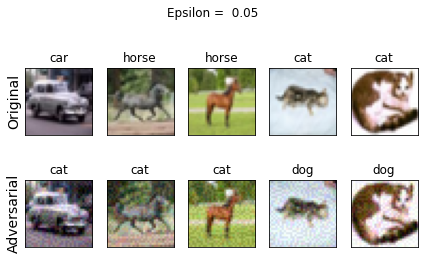

<Figure size 144x864 with 0 Axes>

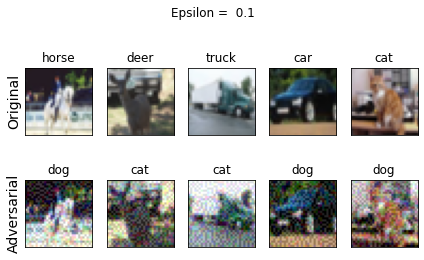

<Figure size 144x864 with 0 Axes>

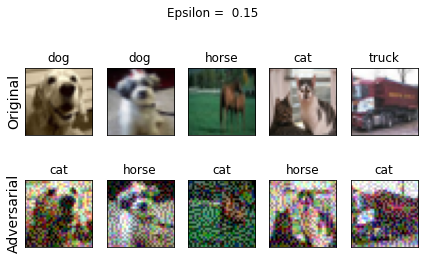

<Figure size 144x864 with 0 Axes>

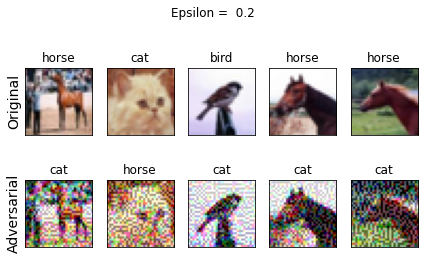

In [40]:
def ax_imshow(ax, img, label):
    img = unnormalize(img)     # unnormalize
    img = np.clip(img, 0., 1.)
    ax.set_xticks([])
    ax.set_yticks([])
    img = np.transpose(img, (1,2,0))
    ax.imshow(img)
    ax.set_title(classes[label])


for i,epsilon in enumerate(epsilons):
  plt.figure(figsize=(2,12))
  fig, axs = plt.subplots(2, n_examples)
  fig.suptitle("Epsilon =  {}".format(epsilon))
  for j in range(len(examples[i])): 
    orig,adv,adv_ex,ori_ex = examples[i][j]
    ax1 = axs[0, j]
    ax2 = axs[1, j]
    ax_imshow(ax2, adv_ex, adv)
    ax_imshow(ax1, ori_ex, orig)
    if j == 0:
      ax1.set_ylabel('Original', fontsize=14)
      ax2.set_ylabel('Adversarial', fontsize=14)
    plt.tight_layout()

# PGD Attack

$$x^{t+1} = \prod_{x+s} (x^t + \alpha sgn(\nabla_xL(\theta,x,y)))$$

In [44]:

import torch.nn as nn
# inspired by https://github.com/Harry24k/PGD-pytorch/blob/master/PGD.ipynb
def pgd_attack(model, image, label, eps, alpha, iters) :

    loss = nn.CrossEntropyLoss()
        
    ori_image = unnormalize(image.data)
        
    for i in range(iters) :    
        image.requires_grad = True
        output = model(image)

        model.zero_grad()
        cost = loss(output, label).to(device)
        cost.backward()

        data_grad = image.grad.data
        image = unnormalize(image)
        adv_image = image + alpha*data_grad.sign()
        eta = adv_image - ori_image
        eta_clip = torch.clamp(eta, min=-eps, max=eps)
        image = torch.clamp(ori_image + eta_clip, min=0, max=1)
        image = transforms.Normalize(mean = norm_mean, std = norm_std)(image).detach()
            
    return image
def pgd_test(model, data_loader, n_examples, eps=0.3, alpha=2/255, iters=7):
  '''
  input: 
    data_loader: data set, batch size = 1
    epsilon: parameter to perform fgsm attack
  return:
    final_acc: accuracy of the model on classifying adversarial examples created based on datas
    adv_examples: n_examples examples of successed adversrial examples
  '''
  correct = 0
  adv_examples = []
  # Loop over all examples in data set, data shape: (C, H, W)
  for i, (data, target) in enumerate(data_loader):

      if i>0 and i%400 == 0:
        current_acc = correct/i
        print(f'Test Accuracy = {current_acc:.4f} [{i:>5d} / {len(data_loader):>5d}]')

      # Send the data and label to the device
      data, target = data.to(device), target.to(device)

      # Forward pass the data through the model
      output = model(data)
      init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
      # If the initial prediction is wrong, dont bother attacking, just move on
      if init_pred.item() != target.item():
          continue

      # Call PGD Attack
      perturbed_data = pgd_attack(model, data, target, eps, alpha, iters)

      # Re-classify the perturbed image
      output = model(perturbed_data)

      # Check for success
      final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
      if final_pred.item() == target.item():
          correct += 1
      else:
          # Save some adv examples for visualization later
          if len(adv_examples) < n_examples:
              adv_ex = perturbed_data.squeeze().detach().cpu()
              ori_ex = data.squeeze().detach().cpu()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex, ori_ex) )
      

  # Calculate final accuracy for this epsilon
  final_acc = correct/float(len(data_loader))
  print("Epsilon: {}, Alpha: {}, Iterations:{} \n Test Accuracy = {} / {} = {}".format(eps,alpha,iters, correct, len(data_loader), final_acc))

  # Return the accuracy and an adversarial example
  return final_acc, adv_examples

In [45]:
acc_pgd, ex_pgd = pgd_test(model, test_loader_1, n_examples = 5)

Test Accuracy = 0.0025 [  400 / 10000]
Test Accuracy = 0.0050 [  800 / 10000]
Test Accuracy = 0.0042 [ 1200 / 10000]
Test Accuracy = 0.0031 [ 1600 / 10000]
Test Accuracy = 0.0030 [ 2000 / 10000]
Test Accuracy = 0.0033 [ 2400 / 10000]
Test Accuracy = 0.0032 [ 2800 / 10000]
Test Accuracy = 0.0031 [ 3200 / 10000]
Test Accuracy = 0.0033 [ 3600 / 10000]
Test Accuracy = 0.0037 [ 4000 / 10000]
Test Accuracy = 0.0041 [ 4400 / 10000]
Test Accuracy = 0.0037 [ 4800 / 10000]
Test Accuracy = 0.0037 [ 5200 / 10000]
Test Accuracy = 0.0036 [ 5600 / 10000]
Test Accuracy = 0.0035 [ 6000 / 10000]
Test Accuracy = 0.0033 [ 6400 / 10000]
Test Accuracy = 0.0032 [ 6800 / 10000]
Test Accuracy = 0.0031 [ 7200 / 10000]
Test Accuracy = 0.0030 [ 7600 / 10000]
Test Accuracy = 0.0031 [ 8000 / 10000]
Test Accuracy = 0.0032 [ 8400 / 10000]
Test Accuracy = 0.0033 [ 8800 / 10000]
Test Accuracy = 0.0033 [ 9200 / 10000]
Test Accuracy = 0.0031 [ 9600 / 10000]
Epsilon: 0.3, Alpha: 0.00784313725490196, Iterations:7 
 Test Ac

<Figure size 144x864 with 0 Axes>

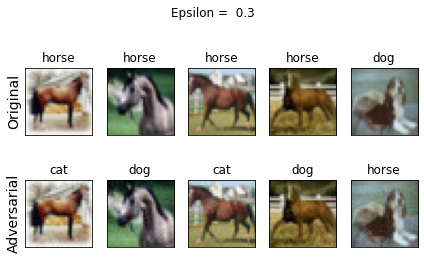

In [46]:
plt.figure(figsize=(2,12))
fig, axs = plt.subplots(2, 5)
fig.suptitle("Epsilon =  {}".format(0.3))
for j in range(len(ex_pgd)): 
  orig,adv,adv_ex,ori_ex = ex_pgd[j]
  ax1 = axs[0, j]
  ax2 = axs[1, j]
  ax_imshow(ax2, adv_ex, adv)
  ax_imshow(ax1, ori_ex, orig)
  if j == 0:
    ax1.set_ylabel('Original', fontsize=14)
    ax2.set_ylabel('Adversarial', fontsize=14)
  plt.tight_layout()

# Random Natural Noise

## Add Random Natural Noise to original images

In [47]:
noise = torch.randn(1, 3, 32, 32)
print(noise)

tensor([[[[-0.0393, -0.9035,  0.5994,  ...,  0.9884, -2.2976, -0.0310],
          [-2.4652, -1.5124,  1.4178,  ...,  0.3263,  0.1182, -0.1411],
          [ 0.8607,  0.2517, -1.5906,  ...,  1.5090, -1.8429,  0.2318],
          ...,
          [ 1.0382,  0.3717,  0.4731,  ...,  0.2579,  0.6980, -0.6177],
          [-0.3339, -0.4894,  0.2073,  ...,  0.3367, -1.5193,  1.8336],
          [ 0.6949, -0.8666,  0.1166,  ..., -1.0459,  0.2705, -0.3669]],

         [[ 0.0952,  0.5618,  1.0423,  ...,  0.1142,  0.4563,  1.8691],
          [ 0.1726,  0.4609,  0.1871,  ..., -0.0838,  0.6355,  0.1574],
          [-0.6051,  0.9753, -1.0321,  ..., -1.3057, -0.4968, -0.6404],
          ...,
          [-0.4719, -0.8704,  0.6063,  ..., -0.0475, -0.4695,  0.9468],
          [-2.1316,  1.7065,  1.4097,  ..., -1.4413,  0.1758,  0.4558],
          [ 1.9901,  0.0495,  1.0922,  ...,  0.5182, -0.2247, -0.9081]],

         [[ 1.1836, -0.9786,  0.7535,  ...,  0.8384, -0.8136,  0.8878],
          [ 0.0334,  2.0642, -

In [122]:

def add_noise(model, image, label, eps) :
 
    noise = torch.randn(1, 3, 32, 32)
    #print(noise)
    data_noise = noise

    image = torch.clamp(image + data_noise, min=image - eps, max=image + eps)
    image = torch.clamp(image, min = 0, max = 1)
            
    return image
def noise_test(model, data_loader, n_examples, eps, alpha):
  '''
  input: 
    data_loader: data set, batch size = 1
    epsilon: parameter to perform fgsm attack
  return:
    final_acc: accuracy of the model on classifying adversarial examples created based on datas
    adv_examples: n_examples examples of successed adversrial examples
  '''
  correct = 0
  noise_examples = []
  # Loop over all examples in data set, data shape: (C, H, W)
  for i, (data, target) in enumerate(data_loader):

      if i>0 and i%400 == 0:
        current_acc = correct/i
        print(f'Test Accuracy = {current_acc:.4f} [{i:>5d} / {len(data_loader):>5d}]')

      # Send the data and label to the device
      data, target = data.to(device), target.to(device)

      # Forward pass the data through the model
      output = model(data)
      init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
      # If the initial prediction is wrong, dont bother attacking, just move on
      if init_pred.item() != target.item():
          continue

      # Call PGD Attack
      perturbed_data = add_noise(model, data, target, eps)

      # Re-classify the perturbed image
      output = model(perturbed_data)

      # Check for success
      final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
      if final_pred.item() == target.item():
          correct += 1
      else:
          # Save some adv examples for visualization later
          if len(noise_examples) < n_examples:
              adv_ex = perturbed_data.squeeze().detach().cpu()
              ori_ex = data.squeeze().detach().cpu()
              noise_examples.append( (init_pred.item(), final_pred.item(), adv_ex, ori_ex) )
      

  # Calculate final accuracy for this epsilon
  final_acc = correct/float(len(data_loader))
  print("Epsilon: {}, Alpha: {} \n Test Accuracy = {} / {} = {}".format(eps,alpha, correct, len(data_loader), final_acc))

  # Return the accuracy and an adversarial example
  return final_acc, noise_examples

In [125]:
acc_noise, ex_noise = noise_test(model, test_loader_1, n_examples = 5, eps = 0, alpha = 0)

Test Accuracy = 0.1175 [  400 / 10000]
Test Accuracy = 0.1050 [  800 / 10000]
Test Accuracy = 0.1217 [ 1200 / 10000]
Test Accuracy = 0.1244 [ 1600 / 10000]
Test Accuracy = 0.1250 [ 2000 / 10000]
Test Accuracy = 0.1304 [ 2400 / 10000]
Test Accuracy = 0.1332 [ 2800 / 10000]
Test Accuracy = 0.1350 [ 3200 / 10000]
Test Accuracy = 0.1350 [ 3600 / 10000]
Test Accuracy = 0.1330 [ 4000 / 10000]
Test Accuracy = 0.1336 [ 4400 / 10000]
Test Accuracy = 0.1350 [ 4800 / 10000]
Test Accuracy = 0.1350 [ 5200 / 10000]
Test Accuracy = 0.1366 [ 5600 / 10000]
Test Accuracy = 0.1375 [ 6000 / 10000]
Test Accuracy = 0.1363 [ 6400 / 10000]
Test Accuracy = 0.1346 [ 6800 / 10000]
Test Accuracy = 0.1358 [ 7200 / 10000]
Test Accuracy = 0.1351 [ 7600 / 10000]
Test Accuracy = 0.1360 [ 8000 / 10000]
Test Accuracy = 0.1352 [ 8400 / 10000]
Test Accuracy = 0.1352 [ 8800 / 10000]
Test Accuracy = 0.1370 [ 9200 / 10000]
Test Accuracy = 0.1373 [ 9600 / 10000]
Epsilon: 0, Alpha: 0 
 Test Accuracy = 1368 / 10000 = 0.1368


<Figure size 144x864 with 0 Axes>

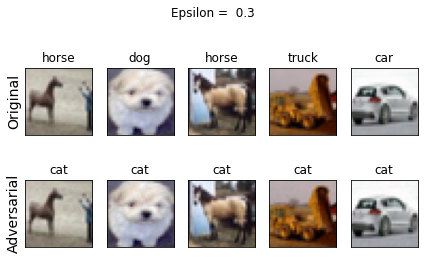

In [58]:
plt.figure(figsize=(2,12))
fig, axs = plt.subplots(2, 5)
fig.suptitle("Epsilon =  {}".format(0.3))
for j in range(len(ex_pgd)): 
  orig,noise,noise_ex,ori_ex = ex_noise[j]
  ax1 = axs[0, j]
  ax2 = axs[1, j]
  ax_imshow(ax2, noise_ex, noise)
  ax_imshow(ax1, ori_ex, orig)
  if j == 0:
    ax1.set_ylabel('Original', fontsize=14)
    ax2.set_ylabel('Adversarial', fontsize=14)
  plt.tight_layout()

## Add Random Natural Noise to perturbed images

In [ ]:
def pgd_noise_test(model, data_loader, n_examples, eps=0.3, alpha=2/255, iters=7):
  '''
  input: 
    data_loader: data set, batch size = 1
    epsilon: parameter to perform fgsm attack
  return:
    final_acc: accuracy of the model on classifying adversarial examples created based on datas
    adv_examples: n_examples examples of successed adversrial examples
  '''
  print("eps = ", eps)
  correct = 0
  adv_examples = []
  # Loop over all examples in data set, data shape: (C, H, W)
  for i, (data, target) in enumerate(data_loader):

      if i>0 and i%400 == 0:
        current_acc = correct/i
        print(f'Test Accuracy = {current_acc:.4f} [{i:>5d} / {len(data_loader):>5d}]')

      # Send the data and label to the device
      data, target = data.to(device), target.to(device)

      # Forward pass the data through the model
      output = model(data)
      init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
      # If the initial prediction is wrong, dont bother attacking, just move on
      if init_pred.item() != target.item():
          continue

      # Call PGD Attack
      perturbed_data = add_noise(model,pgd_attack(model, data, target, eps, alpha, iters),target, 1, 1)

      # Re-classify the perturbed image
      output = model(perturbed_data)

      # Check for success
      final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
      if final_pred.item() == target.item():
          correct += 1
      else:
          # Save some adv examples for visualization later
          if len(adv_examples) < n_examples:
              adv_ex = perturbed_data.squeeze().detach().cpu()
              ori_ex = data.squeeze().detach().cpu()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex, ori_ex) )
      
  print("eps = ", eps)
  # Calculate final accuracy for this epsilon
  final_acc = correct/float(len(data_loader))
  print("Epsilon: {}, Alpha: {}, Iterations:{} \n Test Accuracy = {} / {} = {}".format(eps,alpha,iters, correct, len(data_loader), final_acc))

  # Return the accuracy and an adversarial example
  return final_acc, adv_examples

In [63]:
acc_pgd_n, ex_pgd_n = pgd_noise_test(model, test_loader_1, n_examples = 5)

Test Accuracy = 0.0800 [  400 / 10000]
Test Accuracy = 0.0800 [  800 / 10000]
Test Accuracy = 0.0825 [ 1200 / 10000]
Test Accuracy = 0.0794 [ 1600 / 10000]
Test Accuracy = 0.0820 [ 2000 / 10000]
Test Accuracy = 0.0867 [ 2400 / 10000]
Test Accuracy = 0.0836 [ 2800 / 10000]
Test Accuracy = 0.0809 [ 3200 / 10000]
Test Accuracy = 0.0811 [ 3600 / 10000]
Test Accuracy = 0.0828 [ 4000 / 10000]
Test Accuracy = 0.0830 [ 4400 / 10000]
Test Accuracy = 0.0831 [ 4800 / 10000]
Test Accuracy = 0.0827 [ 5200 / 10000]
Test Accuracy = 0.0818 [ 5600 / 10000]
Test Accuracy = 0.0820 [ 6000 / 10000]
Test Accuracy = 0.0822 [ 6400 / 10000]
Test Accuracy = 0.0822 [ 6800 / 10000]
Test Accuracy = 0.0815 [ 7200 / 10000]
Test Accuracy = 0.0804 [ 7600 / 10000]
Test Accuracy = 0.0800 [ 8000 / 10000]
Test Accuracy = 0.0798 [ 8400 / 10000]
Test Accuracy = 0.0799 [ 8800 / 10000]
Test Accuracy = 0.0801 [ 9200 / 10000]
Test Accuracy = 0.0801 [ 9600 / 10000]
Epsilon: 0.3, Alpha: 0.00784313725490196, Iterations:7 
 Test Ac

ValueError: too many values to unpack (expected 4)

<Figure size 144x864 with 0 Axes>

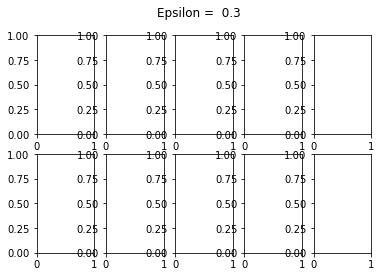

In [94]:
plt.figure(figsize=(2,12))
fig, axs = plt.subplots(2, 5)
fig.suptitle("Epsilon =  {}".format(0.3))
for j in range(len(ex_pgd)): 
  orig,acc_pgd_n,ex_pgd_n,ori_ex = ex_pgd[j]
  ax1 = axs[0, j]
  ax2 = axs[1, j]
  ax_imshow(ax2, ex_pgd_n, acc_pgd_n)
  ax_imshow(ax1, ori_ex, orig)
  if j == 0:
    ax1.set_ylabel('Original', fontsize=14)
    ax2.set_ylabel('Adversarial', fontsize=14)
  plt.tight_layout()

In [103]:
epsilons_n= []
e = 0.001
for i in range(10):
    e += 0.0001
    epsilons_n.append(e)
n_examples = 5
examples_n = []
accuracies_n = []

# Run test for each epsilon
for eps in epsilons_n:
    print('eps = ', eps)
    acc_n, ex_n = pgd_noise_test(model, test_loader_1, eps, n_examples)
    accuracies_n.append(acc_n)
    examples_n.append(ex_n)

eps =  0.0011
Test Accuracy = 0.0775 [  400 / 10000]
Test Accuracy = 0.0712 [  800 / 10000]
Test Accuracy = 0.0700 [ 1200 / 10000]
Test Accuracy = 0.0663 [ 1600 / 10000]
Test Accuracy = 0.0685 [ 2000 / 10000]
Test Accuracy = 0.0683 [ 2400 / 10000]
Test Accuracy = 0.0707 [ 2800 / 10000]
Test Accuracy = 0.0725 [ 3200 / 10000]


KeyboardInterrupt: 

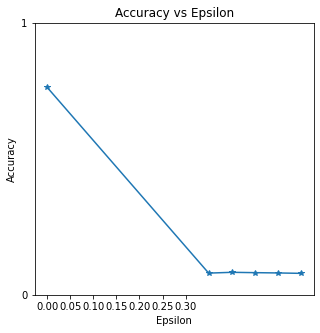

In [98]:
plt.figure(figsize=(5,5))
plt.plot([0] + epsilons, [test_accuracy/100] + accuracies_n, "*-")
plt.yticks(np.arange(0.0, 1.1, step=1))
plt.xticks(np.arange(0.0, .0011, step=0.0001))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

<Figure size 144x864 with 0 Axes>

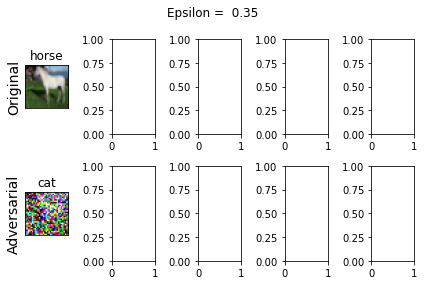

<Figure size 144x864 with 0 Axes>

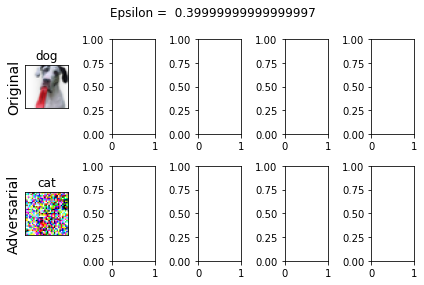

<Figure size 144x864 with 0 Axes>

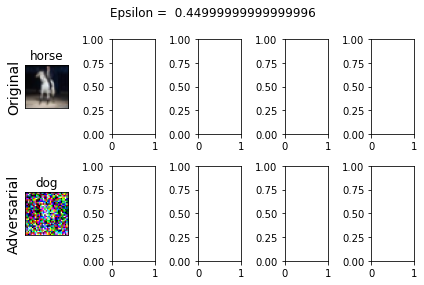

<Figure size 144x864 with 0 Axes>

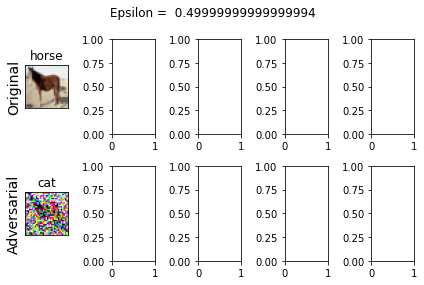

<Figure size 144x864 with 0 Axes>

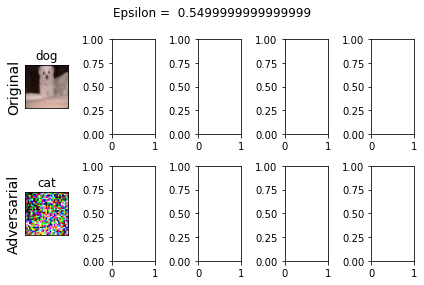

In [102]:
def ax_imshow(ax, img, label):
    img = unnormalize(img)     # unnormalize
    img = np.clip(img, 0., 1.)
    ax.set_xticks([])
    ax.set_yticks([])
    img = np.transpose(img, (1,2,0))
    ax.imshow(img)
    ax.set_title(classes[label])


for i,epsilon in enumerate(epsilons):
  plt.figure(figsize=(2,12))
  fig, axs = plt.subplots(2, n_examples)
  fig.suptitle("Epsilon =  {}".format(epsilon))
  for j in range(len(examples_n[i])): 
    orig,adv,adv_ex,ori_ex = examples_n[i][j]
    ax1 = axs[0, j]
    ax2 = axs[1, j]
    ax_imshow(ax2, adv_ex, adv)
    ax_imshow(ax1, ori_ex, orig)
    if j == 0:
      ax1.set_ylabel('Original', fontsize=14)
      ax2.set_ylabel('Adversarial', fontsize=14)
    plt.tight_layout()

IndexError: list index out of range

<Figure size 144x864 with 0 Axes>

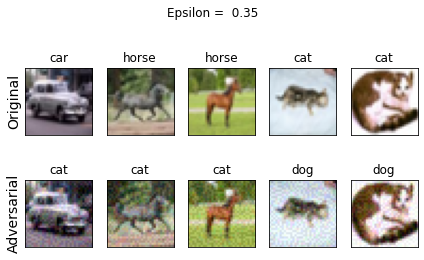

In [89]:
def ax_imshow(ax, img, label):
    img = unnormalize(img)     # unnormalize
    img = np.clip(img, 0., 1.)
    ax.set_xticks([])
    ax.set_yticks([])
    img = np.transpose(img, (1,2,0))
    ax.imshow(img)
    ax.set_title(classes[label])


for i,epsilon in enumerate(epsilons_n):
  plt.figure(figsize=(2,12))
  fig, axs = plt.subplots(2, n_examples)
  fig.suptitle("Epsilon =  {}".format(epsilon))
  for j in range(len(examples[i])+1): 
    orig,noise,noise_ex,ori_ex = examples[i][j]
    ax1 = axs[0, j]
    ax2 = axs[1, j]
    ax_imshow(ax2, noise_ex, noise)
    ax_imshow(ax1, ori_ex, orig)
    if j == 0:
      ax1.set_ylabel('Original', fontsize=14)
      ax2.set_ylabel('Adversarial', fontsize=14)
    plt.tight_layout()